In [1]:
import pandas as pd
from datasets import load_dataset
from transformers import pipeline
from tqdm import tqdm
import os
import re
import matplotlib.pyplot as plt
import torch

/home/mike/miniforge3/envs/modern/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test = pd.read_csv('./data/polnli_test_results.csv')
alts = pd.read_csv('./data/hypothesis_variants.csv')

# merge with alternative hypotheses
test = pd.merge(test, alts, how = 'left', left_on = 'hypothesis', right_on = 'original')

# drop observations that don't have AI generated alternatives
test = test[~test['original'].isna()].reset_index(drop = True)

# drop columns I don't need
test.drop(['augmented_hypothesis', 'base_nli', 'large_nli', 'base_polnli', 'llama', 'large_polnli', 'sonnet', 'original', 'alt4'], axis = 1, inplace = True)

In [3]:
def hypothesis_stability(df):
    """
    Calculate the probability that a document's label changes when using different hypotheses.
    For each document (row), compares all possible pairs of labels to determine how often they differ.

    Accepts the PolNLI_hypothesis_stability_test as a dataframe
    
    Returns:
        float: Probability between 0 and 1 representing how often the label changes when
              using different hypotheses.
    """
    # Each row has 4 prompts, so we have 6 possible pairs per row (4 choose 2)
    n_prompts = 4
    pairs_per_row = (n_prompts * (n_prompts - 1)) // 2  # combinations is n_prompts choose 2
    
    # Count differences for each row
    total_differences = 0
    
    for idx in df.index:
        # Get all labels for this document
        labels = df.iloc[idx]
        
        # Compare each pair of labels
        # We'll have 6 comparisons: (1,2), (1,3), (1,4), (2,3), (2,4), (3,4)
        differences = 0
        for i in range(n_prompts):
            for j in range(i + 1, n_prompts):
                if labels.iloc[i] != labels.iloc[j]:
                    differences += 1
        
        total_differences += differences
    
    # Calculate probability
    # Total comparisons = 6 pairs per row * number of rows
    total_comparisons = pairs_per_row * len(df)
    probability = total_differences / total_comparisons
    
    return probability

# ModernBERT Base

In [7]:
%%time
# Path to the folder containing model checkpoints
model_folder = "training_ModernBase"

# Get a sorted list of checkpoint folders
checkpoints = sorted(
    [
        os.path.join(model_folder, d) for d in os.listdir(model_folder)
        if os.path.isdir(os.path.join(model_folder, d)) and re.match(r'checkpoint-\d+', d)
    ],
    key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1))
)

# Prepare to store stability results
stability_results = []

# Iterate over each checkpoint
for model_path in tqdm(checkpoints, desc="Processing models"):
    # Load the pipeline for the current checkpoint
    #pipe = pipeline("zero-shot-classification", model=model_path, device='cuda', batch_size=64, torch_dtype = torch.bfloat16)
    pipe = pipeline('text-classification', model = model_path, batch_size = 64, torch_dtype = torch.bfloat16)

    colnames = ['hypothesis', 'alt1', 'alt2', 'alt3']
    for col in tqdm(colnames, desc=f'Classifying columns in {model_path}'):
        colname = col + '_label'
        dicts = [{'text':test.loc[i, 'premise'], 'text_pair':test.loc[i, col]} for i in test.index]
        res = pipe(dicts)
        res = [result['label'] for result in res]
        test[colname] = res
        test[colname].replace({'entailment': 0, 'not_entailment': 1}, inplace=True)

    stability = hypothesis_stability(test[['hypothesis_label', 'alt1_label', 'alt2_label', 'alt3_label']])
    checkpoint_number = int(re.search(r'checkpoint-(\d+)', model_path).group(1))
    stability_results.append((checkpoint_number, stability))
    # Print the result for the current model
    print(f"Checkpoint {checkpoint_number}: Stability = {stability}")
    # Convert results to a DataFrame
    stability_df = pd.DataFrame(stability_results, columns=["Checkpoint", "Stability"])
    # Sort by checkpoint for plotting
    stability_df.sort_values("Checkpoint", inplace=True)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be

Checkpoint 10706: Stability = 0.05274684484038604


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 21412: Stability = 0.0503155159613957


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 32118: Stability = 0.04962880475129918


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 42824: Stability = 0.045694135115070526


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 53530: Stability = 0.045248700816629545


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 64236: Stability = 0.0465478841870824


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 74942: Stability = 0.05200445434298441


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 85648: Stability = 0.04508166295471418


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 96354: Stability = 0.04426503340757238


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 107060: Stability = 0.04599109131403118
CPU times: user 3min 2s, sys: 7.2 s, total: 3min 10s
Wall time: 2min 53s


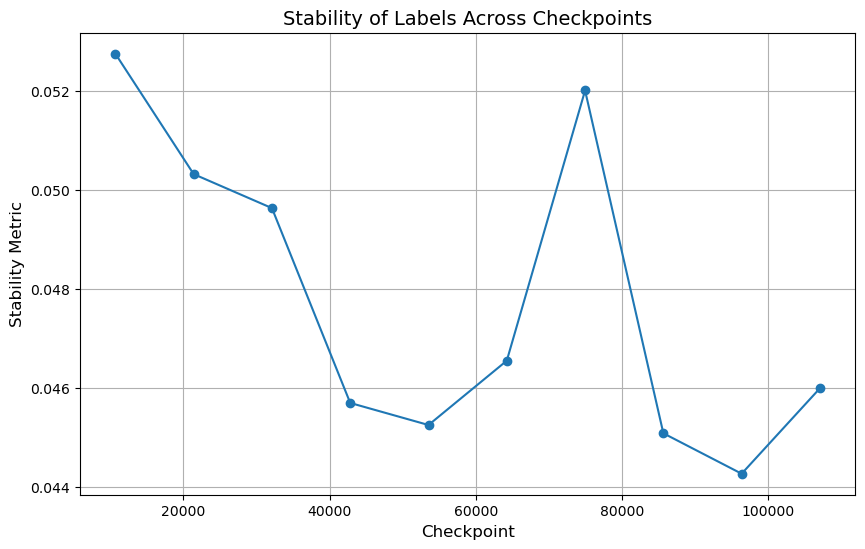

In [8]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(stability_df["Checkpoint"], stability_df["Stability"], marker="o")
plt.title("Stability of Labels Across Checkpoints", fontsize=14)
plt.xlabel("Checkpoint", fontsize=12)
plt.ylabel("Stability Metric", fontsize=12)
plt.grid(True)
plt.show()

# ModernBERT Large

In [6]:
%%time
# Path to the folder containing model checkpoints
model_folder = "training_ModernLarge"

# Get a sorted list of checkpoint folders
checkpoints = sorted(
    [
        os.path.join(model_folder, d) for d in os.listdir(model_folder)
        if os.path.isdir(os.path.join(model_folder, d)) and re.match(r'checkpoint-\d+', d)
    ],
    key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1))
)

# Prepare to store stability results
stability_results = []

# Iterate over each checkpoint
for model_path in tqdm(checkpoints, desc="Processing models"):
    # Load the pipeline for the current checkpoint
    #pipe = pipeline("zero-shot-classification", model=model_path, device='cuda', batch_size=64, torch_dtype = torch.bfloat16)
    pipe = pipeline('text-classification', model = model_path, batch_size = 64, torch_dtype = torch.bfloat16)

    colnames = ['hypothesis', 'alt1', 'alt2', 'alt3']
    for col in tqdm(colnames, desc=f'Classifying columns in {model_path}'):
        colname = col + '_label'
        dicts = [{'text':test.loc[i, 'premise'], 'text_pair':test.loc[i, col]} for i in test.index]
        res = pipe(dicts)
        res = [result['label'] for result in res]
        test[colname] = res
        test[colname].replace({'entailment': 0, 'not_entailment': 1}, inplace=True)

    stability = hypothesis_stability(test[['hypothesis_label', 'alt1_label', 'alt2_label', 'alt3_label']])
    checkpoint_number = int(re.search(r'checkpoint-(\d+)', model_path).group(1))
    stability_results.append((checkpoint_number, stability))
    # Print the result for the current model
    print(f"Checkpoint {checkpoint_number}: Stability = {stability}")
    # Convert results to a DataFrame
    stability_df = pd.DataFrame(stability_results, columns=["Checkpoint", "Stability"])
    # Sort by checkpoint for plotting
    stability_df.sort_values("Checkpoint", inplace=True)

Device set to use cuda:0                                                                 | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.in

Checkpoint 10705: Stability = 0.032015590200445435


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 21410: Stability = 0.031310319227913885


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 32115: Stability = 0.035653303637713435


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 42820: Stability = 0.037305122494432075


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 53525: Stability = 0.033741648106904235


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 64230: Stability = 0.03789903489235338


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 74935: Stability = 0.02969561989606533


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 85640: Stability = 0.03275798069784707


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 96345: Stability = 0.030753526354862656


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 107050: Stability = 0.030957683741648107
CPU times: user 8min 8s, sys: 10.7 s, total: 8min 18s
Wall time: 7min 58s


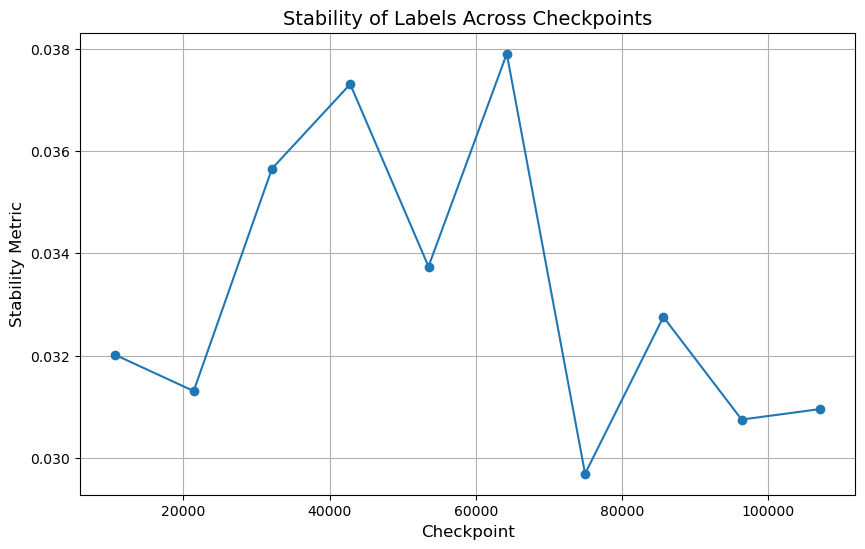

In [7]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(stability_df["Checkpoint"], stability_df["Stability"], marker="o")
plt.title("Stability of Labels Across Checkpoints", fontsize=14)
plt.xlabel("Checkpoint", fontsize=12)
plt.ylabel("Stability Metric", fontsize=12)
plt.grid(True)
plt.show()

# DeBERTa Base

In [9]:
%%time
# Path to the folder containing model checkpoints
model_folder = "training_base"

# Get a sorted list of checkpoint folders
checkpoints = sorted(
    [
        os.path.join(model_folder, d) for d in os.listdir(model_folder)
        if os.path.isdir(os.path.join(model_folder, d)) and re.match(r'checkpoint-\d+', d)
    ],
    key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1))
)

# Prepare to store stability results
stability_results = []

# Iterate over each checkpoint
for model_path in tqdm(checkpoints, desc="Processing models"):
    # Load the pipeline for the current checkpoint
    #pipe = pipeline("zero-shot-classification", model=model_path, device='cuda', batch_size=64, torch_dtype = torch.bfloat16)
    pipe = pipeline('text-classification', model = model_path, batch_size = 64, torch_dtype = torch.bfloat16)

    colnames = ['hypothesis', 'alt1', 'alt2', 'alt3']
    for col in tqdm(colnames, desc=f'Classifying columns in {model_path}'):
        colname = col + '_label'
        dicts = [{'text':test.loc[i, 'premise'], 'text_pair':test.loc[i, col]} for i in test.index]
        res = pipe(dicts)
        res = [result['label'] for result in res]
        test[colname] = res
        test[colname].replace({'entailment': 0, 'not_entailment': 1}, inplace=True)

    stability = hypothesis_stability(test[['hypothesis_label', 'alt1_label', 'alt2_label', 'alt3_label']])
    checkpoint_number = int(re.search(r'checkpoint-(\d+)', model_path).group(1))
    stability_results.append((checkpoint_number, stability))
    # Print the result for the current model
    print(f"Checkpoint {checkpoint_number}: Stability = {stability}")
    # Convert results to a DataFrame
    stability_df = pd.DataFrame(stability_results, columns=["Checkpoint", "Stability"])
    # Sort by checkpoint for plotting
    stability_df.sort_values("Checkpoint", inplace=True)

Device set to use cuda:0                                                                 | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.in

Checkpoint 10706: Stability = 0.03945805493689681


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 21412: Stability = 0.03303637713437268


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 32118: Stability = 0.03771343726800297


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 42824: Stability = 0.026002227171492205


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 53530: Stability = 0.037379361544172235


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 64236: Stability = 0.04832962138084632


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 74942: Stability = 0.04901633259094284


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 85648: Stability = 0.045805493689680774


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 96354: Stability = 0.03693392724573125


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors
<timed exec>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.n

Checkpoint 107060: Stability = 0.03533778767631774
CPU times: user 7min 42s, sys: 7.99 s, total: 7min 50s
Wall time: 7min 37s


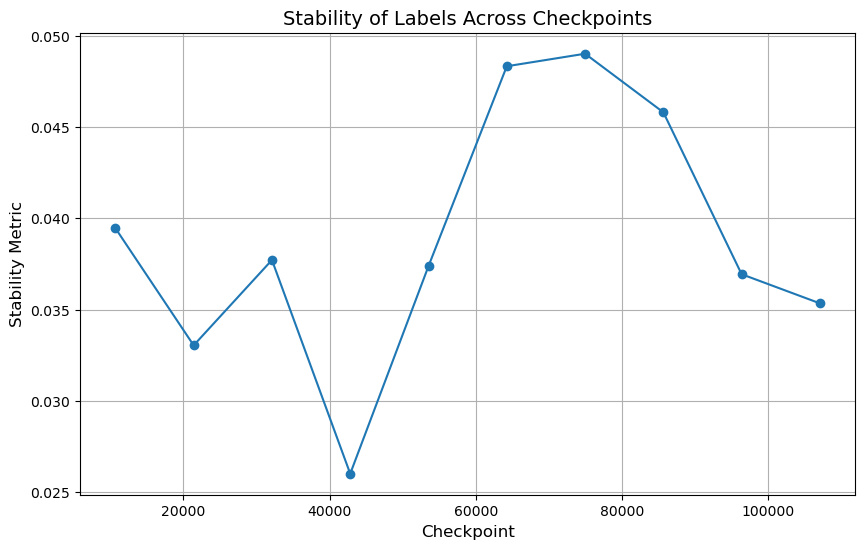

In [10]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(stability_df["Checkpoint"], stability_df["Stability"], marker="o")
plt.title("Stability of Labels Across Checkpoints", fontsize=14)
plt.xlabel("Checkpoint", fontsize=12)
plt.ylabel("Stability Metric", fontsize=12)
plt.grid(True)
plt.show()

In [3]:
from typing import Union, List, Tuple

def calculate_model_stability(model_input, test_data, device='cuda', batch_size=64):
    """
    Calculate stability metrics for transformer models.
    
    Args:
        model_input: Either a path to folder containing checkpoints or a model name/path
        test_data: DataFrame containing 'premise', 'hypothesis', 'alt1', 'alt2', 'alt3', 'alt4' columns
        device: Device to run inference on ('cuda' or 'cpu')
        batch_size: Batch size for inference
    
    Returns:
        For single model: float representing stability score
        For checkpoint directory: DataFrame containing checkpoint numbers and stability scores
    """
    # Validate input data
    required_columns = ['premise', 'hypothesis', 'alt1', 'alt2', 'alt3']
    missing_columns = [col for col in required_columns if col not in test_data.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns in test_data: {missing_columns}")
    
    def process_single_model(model_path, checkpoint_num=None):
        """Process a single model and return its stability metric"""
        pipe = pipeline("zero-shot-classification", 
                       model=model_path, 
                       device=device, 
                       batch_size=batch_size)
        
        # Create a copy of test data
        test = test_data.copy()
        
        # Process each column
        colnames = ['hypothesis', 'alt1', 'alt2', 'alt3']
        for col in tqdm(colnames, desc=f'Classifying columns in {model_path}'):
            colname = col + '_label'
            test[colname] = 0
            
            for i in test.index:
                hypothesis = test.loc[i, col]
                sample = test.loc[i, 'premise']
                res = pipe(sample, hypothesis, hypothesis_template='{}', multi_label=False)
                test.loc[i, colname] = round(res['scores'][0])
            
            test[colname].replace({0: 1, 1: 0}, inplace=True)
            test[colname] = test[colname].astype(int)
        
        # Calculate stability
        alt_columns = ['alt1_label', 'alt2_label', 'alt3_label']
        total_differences = sum((test[col] != test['hypothesis_label']).sum() 
                              for col in alt_columns)
        stability = total_differences / (len(test) * 4)
        
        return checkpoint_num, stability
    
    # Handle different input types
    if isinstance(model_input, str):
        if os.path.isdir(model_input):
            # Process folder of checkpoints
            checkpoints = sorted(
                [os.path.join(model_input, d) for d in os.listdir(model_input)
                 if os.path.isdir(os.path.join(model_input, d)) 
                 and re.match(r'checkpoint-\d+', d)],
                key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1))
            )
            
            if not checkpoints:
                raise ValueError(f"No checkpoint folders found in {model_input}")
            
            stability_results = []
            for model_path in tqdm(checkpoints, desc="Processing models"):
                checkpoint_num = int(re.search(r'checkpoint-(\d+)', model_path).group(1))
                checkpoint_num, stability = process_single_model(model_path, checkpoint_num)
                stability_results.append((checkpoint_num, stability))
                print(f"Checkpoint {checkpoint_num}: Stability = {stability}")
            
            # Return DataFrame for multiple checkpoints
            stability_df = pd.DataFrame(stability_results, columns=["Checkpoint", "Stability"])
            stability_df.sort_values("Checkpoint", inplace=True)
            return stability_df
        
        else:
            # Process single model and return just the stability score
            _, stability = process_single_model(model_input)
            print(f"Model stability = {stability}")
            return stability

Device set to use cuda%|                                                                 | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment

Checkpoint 10706: Stability = 0.06366926503340757



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the

Checkpoint 21412: Stability = 0.0388641425389755



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the

Checkpoint 32118: Stability = 0.03772271714922049



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the

Checkpoint 42824: Stability = 0.03635857461024499



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the

Checkpoint 53530: Stability = 0.03917037861915367



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the

Checkpoint 64236: Stability = 0.03744432071269488



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the

Checkpoint 74942: Stability = 0.03599665924276169



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the

Checkpoint 85648: Stability = 0.03878062360801782



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the

Checkpoint 96354: Stability = 0.036442093541202675



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_7668/2325835054.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the

Checkpoint 107060: Stability = 0.038084632516703784


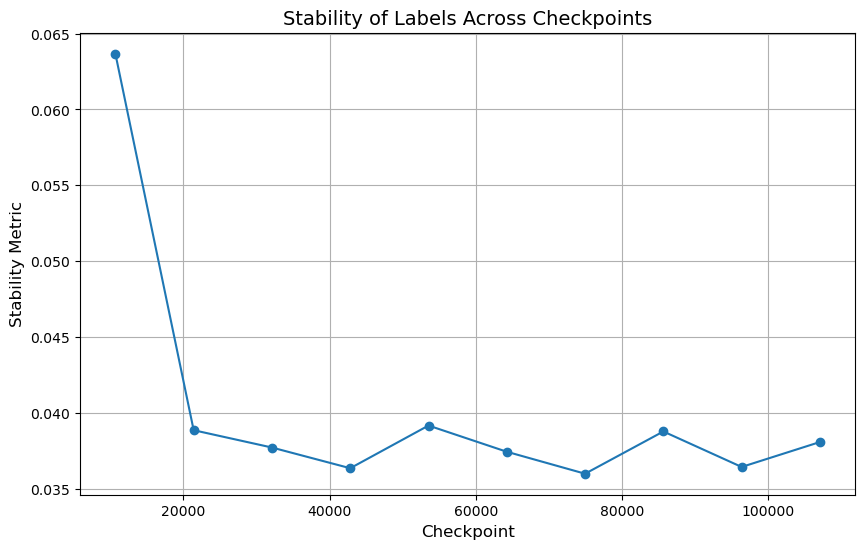

In [15]:
import os
import re
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Path to the folder containing model checkpoints
model_folder = "training_Modern_tasksource2"

# Get a sorted list of checkpoint folders
checkpoints = sorted(
    [
        os.path.join(model_folder, d) for d in os.listdir(model_folder)
        if os.path.isdir(os.path.join(model_folder, d)) and re.match(r'checkpoint-\d+', d)
    ],
    key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1))
)

# Prepare to store stability results
stability_results = []

# Iterate over each checkpoint
for model_path in tqdm(checkpoints, desc="Processing models"):
    # Load the pipeline for the current checkpoint
    pipe = pipeline("zero-shot-classification", model=model_path, device='cuda', batch_size=64)

    colnames = ['hypothesis', 'alt1', 'alt2', 'alt3']
    for col in tqdm(colnames, desc=f'Classifying columns in {model_path}'):
        colname = col + '_label'
        test[colname] = 0
        for i in test.index:
            hypothesis = test.loc[i, col]
            sample = test.loc[i, 'premise']
            res = pipe(sample, hypothesis, hypothesis_template='{}', multi_label=False)
            test.loc[i, colname] = round(res['scores'][0])
        test[colname].replace({0: 1, 1: 0}, inplace=True)
        test[colname] = test[colname].astype(int)

    # Calculate the total number of differences
    alt_columns = ['alt1_label', 'alt2_label', 'alt3_label']
    total_differences = 0

    for col in alt_columns:
        total_differences += (test[col] != test['hypothesis_label']).sum()

    # Calculate stability metric
    stability = total_differences / (len(test) * 4)

    # Extract checkpoint number and store results
    checkpoint_number = int(re.search(r'checkpoint-(\d+)', model_path).group(1))
    stability_results.append((checkpoint_number, stability))

    # Print the result for the current model
    print(f"Checkpoint {checkpoint_number}: Stability = {stability}")

# Convert results to a DataFrame
stability_df = pd.DataFrame(stability_results, columns=["Checkpoint", "Stability"])

# Sort by checkpoint for plotting
stability_df.sort_values("Checkpoint", inplace=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(stability_df["Checkpoint"], stability_df["Stability"], marker="o")
plt.title("Stability of Labels Across Checkpoints", fontsize=14)
plt.xlabel("Checkpoint", fontsize=12)
plt.ylabel("Stability Metric", fontsize=12)
plt.grid(True)
plt.show()

# DEBATE 1.1

In [13]:
# Path to the folder containing model checkpoints
model_folder = "training_ModernBase"

# Get a sorted list of checkpoint folders
checkpoints = sorted(
    [
        os.path.join(model_folder, d) for d in os.listdir(model_folder)
        if os.path.isdir(os.path.join(model_folder, d)) and re.match(r'checkpoint-\d+', d)
    ],
    key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1))
)

# Prepare to store stability results
stability_results = []

# Iterate over each checkpoint
for model_path in tqdm(checkpoints, desc="Processing models"):
    # Load the pipeline for the current checkpoint
    pipe = pipeline("zero-shot-classification", model=model_path, device='cuda', batch_size=64, torch_dtype=torch.bfloat16)

    colnames = ['hypothesis', 'alt1', 'alt2', 'alt3', 'alt4']
    for col in tqdm(colnames, desc=f'Classifying columns in {model_path}'):
        colname = col + '_label'
        test[colname] = 0
        for i in test.index:
            hypothesis = test.loc[i, col]
            sample = test.loc[i, 'premise']
            res = pipe(sample, hypothesis, hypothesis_template='{}', multi_label=False)
            test.loc[i, colname] = round(res['scores'][0])
        test[colname].replace({0: 1, 1: 0}, inplace=True)
        test[colname] = test[colname].astype(int)

    # Calculate the total number of differences
    alt_columns = ['alt1_label', 'alt2_label', 'alt3_label', 'alt4_label']
    total_differences = 0

    for col in alt_columns:
        total_differences += (test[col] != test['hypothesis_label']).sum()

    # Calculate stability metric
    stability = total_differences / (len(test) * 4)

    # Extract checkpoint number and store results
    checkpoint_number = int(re.search(r'checkpoint-(\d+)', model_path).group(1))
    stability_results.append((checkpoint_number, stability))

    # Print the result for the current model
    print(f"Checkpoint {checkpoint_number}: Stability = {stability}")

# Convert results to a DataFrame
stability_df = pd.DataFrame(stability_results, columns=["Checkpoint", "Stability"])

# Sort by checkpoint for plotting
stability_df.sort_values("Checkpoint", inplace=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(stability_df["Checkpoint"], stability_df["Stability"], marker="o")
plt.title("Stability of Labels Across Checkpoints", fontsize=14)
plt.xlabel("Checkpoint", fontsize=12)
plt.ylabel("Stability Metric", fontsize=12)
plt.grid(True)
plt.show()

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Device set to use cuda

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset]
/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy 

Checkpoint 10706: Stability = 0.05155902004454343


Device set to use cuda

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Checkpoint 21412: Stability = 0.03535634743875279


Device set to use cuda

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Checkpoint 32118: Stability = 0.04768930957683742


Device set to use cuda

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Checkpoint 42824: Stability = 0.0446826280623608


Device set to use cuda

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Checkpoint 53530: Stability = 0.046575723830734966


Device set to use cuda

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Checkpoint 64236: Stability = 0.045155902004454344


Device set to use cuda

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Checkpoint 74942: Stability = 0.04665924276169265


Device set to use cuda

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Checkpoint 85648: Stability = 0.04665924276169265


Device set to use cuda

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[colname].replace({0: 1, 1: 0}, inplace=True)

/tmp/ipykernel_8992/3146739129.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Checkpoint 96354: Stability = 0.04821826280623608


Device set to use cuda

Classifying columns in training_ModernBase/checkpoint-107060:   0%|                       | 0/5 [00:22<?, ?it/s]
Processing models:  90%|██████████████████████████████████████████████████▍     | 9/10 [44:38<04:57, 297.60s/it]


KeyboardInterrupt: 

# DEBATE Base

In [ ]:
#model = "mlburnham/Political_DEBATE_base_v1.0"
model = "training_Modern_tasksource2/checkpoint-85648"
pipe = pipeline("zero-shot-classification", model = model, device = 'cuda', batch_size = 64)

colnames = ['hypothesis', 'alt1', 'alt2', 'alt3', 'alt4']
for col in tqdm(colnames, desc = 'Classifying columns'):
    colname = col + '_label'
    test[colname] = 0
    for i in test.index:
        hypothesis = test.loc[i, col]
        sample = test.loc[i, 'premise']
        res = pipe(sample, hypothesis, hypothesis_template = '{}', multi_label = False)
        test.loc[i, colname] = round(res['scores'][0])
    test[colname].replace({0:1, 1:0}, inplace = True)

    test[colname] = test[colname].astype(int)

# Add labels to dataframe and count the number of differences
alt_columns = ['alt1_label', 'alt2_label', 'alt3_label', 'alt4_label']
# Initialize a counter for differences
total_differences = 0

# Iterate through each alternative label column
for col in alt_columns:
    # Compare the values with 'hypothesis_label' and sum the differences
    total_differences += (test[col] != test['hypothesis_label']).sum()

# Print the result
print(f"Total number of differences: {total_differences}")

print(total_differences/(8980*4))

In [8]:
alt_columns = ['alt1_label', 'alt2_label', 'alt3_label', 'alt4_label']

# Initialize a counter for differences
total_differences = 0

# Iterate through each alternative label column
for col in alt_columns:
    # Compare the values with 'hypothesis_label' and sum the differences
    total_differences += (test[col] != test['hypothesis_label']).sum()

# Print the result
print(f"Total number of differences: {total_differences}")

Total number of differences: 894
Total number of differences: 894


In [11]:
total_differences/(8980*4)

0.024888641425389754

In [12]:
test.to_csv('hypothesis_stability.csv', index = False)

# DEBATE Large

In [23]:
model = "mlburnham/Political_DEBATE_large_v1.0"
pipe = pipeline("zero-shot-classification", model = model, device = 'mps', batch_size = 64)

In [24]:
%%time
colname = 'original_label'
test[colname] = 0

for i in test.index:
    hypothesis = test.loc[i, 'hypothesis']
    sample = test.loc[i, 'premise']
    res = pipe(sample, hypothesis, hypothesis_template = '{}', multi_label = False)
    test.loc[i, colname] = round(res['scores'][0])
test[colname].replace({0:1, 1:0}, inplace = True)

test[colname] = test[colname].astype(int)

CPU times: user 9min 19s, sys: 54.9 s, total: 10min 14s
Wall time: 24min 4s
CPU times: user 9min 19s, sys: 54.9 s, total: 10min 14s
Wall time: 24min 4s


<timed exec>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [25]:
colnames = ['alt1', 'alt2', 'alt3', 'alt4']
for col in colnames:
    colname = col + '_label'
    test[colname] = 0
    for i in test.index:
        hypothesis = test.loc[i, col]
        sample = test.loc[i, 'premise']
        res = pipe(sample, hypothesis, hypothesis_template = '{}', multi_label = False)
        test.loc[i, colname] = round(res['scores'][0])
    test[colname].replace({0:1, 1:0}, inplace = True)

    test[colname] = test[colname].astype(int)

,premise,hypothesis,entailment,dataset,task,alt1,alt2,alt3,alt4,original_label
0,Transport workers strike to protest rising fue...,The event described in this text is a strike.,0,mlburnham/scad_event_entailment,event extraction,The occurrence detailed in this passage is a s...,The situation outlined in this document is a s...,The incident mentioned in this text is a strike.,The event described in this text is a strike.,0
1,Municipal workers strike over pay.,The event described in this text is a strike.,0,mlburnham/scad_event_entailment,event extraction,The occurrence detailed in this passage is a s...,The situation outlined in this document is a s...,The incident mentioned in this text is a strike.,The event described in this text is a strike.,0
2,Niger's mining sector strikes.,The event described in this text is a strike.,0,mlburnham/scad_event_entailment,event extraction,The occurrence detailed in this passage is a s...,The situation outlined in this document is a s...,The incident mentioned in this text is a strike.,The event described in this text is a strike.,0
3,Separatist movement protests detention of lead...,The event described in this text is a strike.,0,mlburnham/scad_event_entailment,event extraction,The occurrence detailed in this passage is a s...,The situation outlined in this document is a s...,The incident mentioned in this text is a strike.,The event described in this text is a strike.,0
4,Janitors and hospital support staff staged a s...,The event described in this text is a strike.,0,mlburnham/scad_event_entailment,event extraction,The occurrence detailed in this passage is a s...,The situation outlined in this document is a s...,The incident mentioned in this text is a strike.,The event described in this text is a strike.,0
...,...,...,...,...,...,...,...,...,...,...
8975,Encouraging Public Offerings Act of 2019\nThis...,This text is about finance and financial sector.,0,mlburnham/bill_summary_entailment,topic classification,This document discusses finance and the financ...,The content here pertains to finance and the f...,This writing covers topics related to finance ...,This text is about finance and financial sector.,0
8976,Cesar Chavez Commemorative Coin Act\nThis bill...,This text is about finance and financial sector.,0,mlburnham/bill_summary_entailment,topic classification,This document discusses finance and the financ...,The content here pertains to finance and the f...,This writing covers topics related to finance ...,This text is about finance and financial sector.,1
8977,Outsourcing Accountability Act of 2017\nThis b...,This text is about finance and financial sector.,0,mlburnham/bill_summary_entailment,topic classification,This document discusses finance and the financ...,The content here pertains to finance and the f...,This writing covers topics related to finance ...,This text is about finance and financial sector.,0
8978,Prioritizing Our Workers Act\nThis bill includ...,This text is about finance and financial sector.,0,mlburnham/bill_summary_entailment,topic classification,This document discusses finance and the financ...,The content here pertains to finance and the f...,This writing covers topics related to finance ...,This text is about finance and financial sector.,0
